In [1]:
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"
sys.path.append(str(src_path))

import data_preprocessing as dp
import model_evaluation as me

In [24]:
import pandas as pd
import numpy as np
import random

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import re
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

import seaborn as sns
import matplotlib.pyplot as plt


In [25]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dropout, Activation, Bidirectional
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasClassifier

In [4]:
sns.set(context = 'notebook', style = 'whitegrid')

# get data using andrew's clean data functions

In [5]:
csv_path = data_path / 'combined_no_lem.csv'
cleaned_df = pd.read_csv(csv_path)

In [6]:
cleaned_df.dropna(inplace=True)

In [7]:
cleaned_df.head(5)

,emotion,txt_cleaned
0,0,product_target hrs tweeting riseaustin dead ne...
1,2,know awesome ipadiphone product_target youll l...
2,2,wait product_target also sale sxsw
3,0,hope years festival isnt crashy years iphone p...
4,2,great stuff fri sxsw marissa mayer product_tar...


In [8]:
y = cleaned_df['emotion']
y

0        0
1        2
2        2
3        0
4        2
        ..
22631    0
22632    0
22633    0
22634    0
22635    0
Name: emotion, Length: 22606, dtype: int64

In [9]:
X = cleaned_df['txt_cleaned']
X

0        product_target hrs tweeting riseaustin dead ne...
1        know awesome ipadiphone product_target youll l...
2                       wait product_target also sale sxsw
3        hope years festival isnt crashy years iphone p...
4        great stuff fri sxsw marissa mayer product_tar...
                               ...                        
22631    literally reason want go rest line kind snooze...
22632                          anyone else completely sold
22633                              recycled fuck coachella
22634                    line already fake like every year
22635                                        fersure thing
Name: txt_cleaned, Length: 22606, dtype: object

In [10]:
y.value_counts()

2    8213
0    8062
1    6331
Name: emotion, dtype: int64

In [11]:
X.isna().value_counts()

False    22606
Name: txt_cleaned, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_tr, X_v, y_tr, y_v = train_test_split(X_train, y_train, test_size=.1)

# tokenize tweets

In [13]:
X_train_list = list(X_train)
X_test_list = list(X_test)
X_tr_list = list(X_tr)
X_v_list = list(X_v)

X_train_corpus = []
X_tr_corpus = []
for tweet in X_train_list:
    X_train_corpus.extend(tweet.split(' '))
for tweet in X_tr_list:
    X_tr_corpus.extend(tweet.split(' '))
    
X_train_unique = len(set(X_train_corpus))
X_tr_unique = len(set(X_tr_corpus))

In [14]:
sequence_length = 100

partial_tokenizer = text.Tokenizer(num_words=X_tr_unique)
full_tokenizer = text.Tokenizer(num_words=X_train_unique)

partial_tokenizer.fit_on_texts(X_tr_list)
full_tokenizer.fit_on_texts(X_train_list)

X_tr_tokenized = partial_tokenizer.texts_to_sequences(X_tr_list)
X_v_tokenized = partial_tokenizer.texts_to_sequences(X_v_list)
X_train_tokenized= full_tokenizer.texts_to_sequences(X_train_list)
X_test_tokenized= full_tokenizer.texts_to_sequences(X_test_list)

X_tr_tokens = sequence.pad_sequences(X_tr_tokenized, maxlen=sequence_length)
X_v_tokens = sequence.pad_sequences(X_v_tokenized, maxlen=sequence_length)
X_train_tokens = sequence.pad_sequences(X_train_tokenized, maxlen=sequence_length)
X_test_tokens = sequence.pad_sequences(X_test_tokenized, maxlen=sequence_length)

#### ^^^ modified for train_test_split variables up to here

# construct CNN with embedding layer

In [15]:
partial_model = Sequential()

embedding_size = 64
partial_model.add(Embedding(input_dim=len(set(X_tr_corpus)), output_dim=embedding_size, input_length=sequence_length))
partial_model.add(Conv1D(filters=64, kernel_size=5, activation='tanh'))
partial_model.add(Dropout(0.7))
partial_model.add(MaxPooling1D(pool_size=3))
partial_model.add(Flatten())
partial_model.add(Dense(units=30, activation='tanh'))
partial_model.add(Dropout(.5))
partial_model.add(Dense(units=10, activation='tanh'))
partial_model.add(Dropout(.5))
partial_model.add(Dense(units=3, activation='softmax'))
partial_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model on tokenized data

In [16]:
partial_model.fit(X_tr_tokens, pd.get_dummies(y_tr), validation_data=(X_v_tokens, pd.get_dummies(y_v)), epochs=10, batch_size=512)

Epoch 1/10
32/32 [==============================] - 4s 123ms/step - loss: 1.0866 - accuracy: 0.3816 - val_loss: 1.0590 - val_accuracy: 0.4256
Epoch 2/10
32/32 [==============================] - 4s 132ms/step - loss: 1.0019 - accuracy: 0.4887 - val_loss: 0.9386 - val_accuracy: 0.5688
Epoch 3/10
32/32 [==============================] - 4s 116ms/step - loss: 0.8869 - accuracy: 0.5975 - val_loss: 0.8763 - val_accuracy: 0.6053
Epoch 4/10
32/32 [==============================] - 3s 99ms/step - loss: 0.7560 - accuracy: 0.6842 - val_loss: 0.8304 - val_accuracy: 0.6412
Epoch 5/10
32/32 [==============================] - 3s 98ms/step - loss: 0.6345 - accuracy: 0.7494 - val_loss: 0.8256 - val_accuracy: 0.6457
Epoch 6/10
32/32 [==============================] - 3s 93ms/step - loss: 0.5270 - accuracy: 0.8038 - val_loss: 0.8620 - val_accuracy: 0.6258
Epoch 7/10
32/32 [==============================] - 3s 93ms/step - loss: 0.4389 - accuracy: 0.8454 - val_loss: 0.9143 - val_accuracy: 0.6202
Epoch 8/10

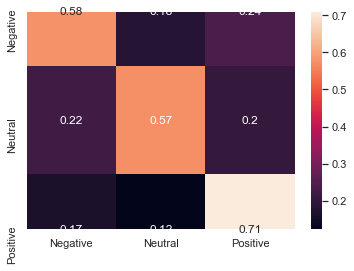

In [17]:
me.plot_confusion_matrix(y_v, np.argmax(partial_model.predict(X_v_tokens), axis=1))

In [18]:
confusion_matrix(y_v, np.argmax(partial_model.predict(X_v_tokens), axis=1))

array([[369, 117, 153],
       [122, 314, 112],
       [104,  77, 441]])

# train model on full train split for validation on 'test'

In [19]:
def make_CNN():
    model = Sequential()

    embedding_size = 64
    model.add(Embedding(input_dim=len(set(X_train_corpus)), output_dim=embedding_size, input_length=sequence_length))
    model.add(Conv1D(filters=64, kernel_size=5, activation='tanh'))
    model.add(Dropout(0.7))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(units=30, activation='tanh'))
    model.add(Dropout(.5))
    model.add(Dense(units=10, activation='tanh'))
    model.add(Dropout(.5))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

final_model = KerasClassifier(twoLayerFeedForward, epochs=100, batch_size=500, verbose=0)

In [20]:
final_model.fit(X_train_tokens, pd.get_dummies(y_train), validation_data=(X_test_tokens, pd.get_dummies(y_test)), epochs=5, batch_size=512)

Epoch 1/5
36/36 [==============================] - 5s 129ms/step - loss: 1.0835 - accuracy: 0.3934 - val_loss: 1.0514 - val_accuracy: 0.4513
Epoch 2/5
36/36 [==============================] - 4s 101ms/step - loss: 0.9881 - accuracy: 0.5076 - val_loss: 0.9546 - val_accuracy: 0.5436
Epoch 3/5
36/36 [==============================] - 4s 112ms/step - loss: 0.8697 - accuracy: 0.5985 - val_loss: 0.8808 - val_accuracy: 0.6212
Epoch 4/5
36/36 [==============================] - 4s 113ms/step - loss: 0.7317 - accuracy: 0.6884 - val_loss: 0.8383 - val_accuracy: 0.6413
Epoch 5/5
36/36 [==============================] - 4s 102ms/step - loss: 0.6114 - accuracy: 0.7603 - val_loss: 0.8454 - val_accuracy: 0.6402


In [ ]:
me.plot_confusion_matrix(y_test, np.argmax(partial_model.predict(X_test_tokens), axis=1))

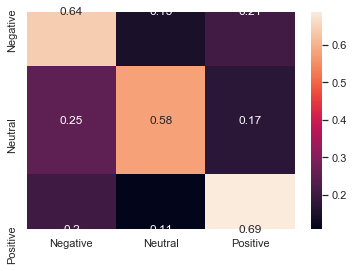

In [21]:
plot_confusion_matrix(full_model, X_test_tokens, y_test)

In [22]:
confusion_matrix(y_test, np.argmax(full_model.predict(X_test_tokens), axis=1))

array([[1048,  243,  342],
       [ 321,  747,  222],
       [ 326,  173, 1100]])

In [ ]:
def get_gradient():
    '''
    given a start and end color, returns a list of color values in a gradient
    
    Parameter:
    --start: a hexidecimal value for the first color
    --end: a hexidecimal value for the last color
    --resolution: the number of gradient values to return
    
    Return:
    --gradient: a list of strings representing the hexidecimal values of the gradient colors
    
    '''

In [26]:
from colour import Color
red = Color("#212D74")
colors = list(red.range_to(Color("#7890CD"),10))

ModuleNotFoundError: No module named 'colour'